In [1]:
import numpy as np
import torch
from transformer_lens import HookedTransformer
from sae_lens import SAE
import matplotlib.pyplot as plt

/home/ubuntu/investigaton-NLP-1/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
# Chat GPT me jura que sae_release es así y que sae_id es asá. Fuente: https://huggingface.co/ctigges/pythia-70m-deduped__res-sm_processed/tree/main
sae_base_model_name = "EleutherAI/pythia-70m-deduped"
sae_release = "ctigges/pythia-70m-deduped__res-sm_processed"
sae_id      = "5-res-sm"
hook_name   = "blocks.5.hook_resid_post"

In [ ]:
# sae_base_model_name = "gemma-2b-it"
# sae_release = "gemma-2b-it-res-jb"
# sae_id = "blocks.12.hook_resid_post"
# hook_name = "blocks.12.hook_resid_post" 

In [5]:
sae_base_model = HookedTransformer.from_pretrained_no_processing(
    sae_base_model_name,
    device=device,
    dtype=torch.bfloat16,
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


In [6]:
sae, sae_cfg, sparsity = SAE.from_pretrained(
    release=sae_release,
    sae_id=sae_id,
    device=device,
)
sae.eval()

/tmp/ipykernel_2387/1603754695.py:1: DeprecationWarning: Unpacking SAE objects is deprecated. SAE.from_pretrained() now returns only the SAE object. Use SAE.from_pretrained_with_cfg_and_sparsity() to get the config dict and sparsity as well.
  sae, sae_cfg, sparsity = SAE.from_pretrained(


StandardSAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

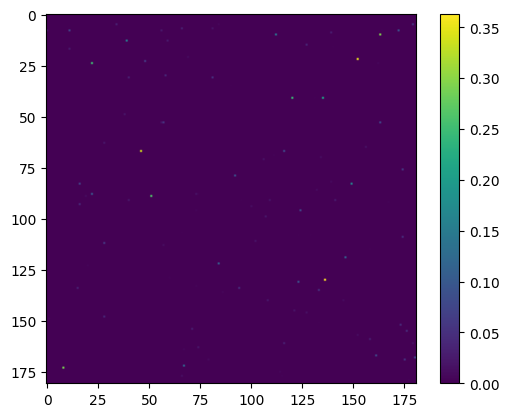

In [7]:
def sae_encode_text(model, sae, text, hook_name, prepend_bos=True):
    ''''
    Cada pixel corresponde a una feature del SAE.
    El promedio o el máximo se hace sobre los tokens.
    '''
    with torch.no_grad():
        tokens = model.to_tokens(text, prepend_bos=prepend_bos) # Pythia, Gemma, etc use BOS
        _, cache = model.run_with_cache(tokens, names_filter=[hook_name])
        acts = cache[hook_name]
        acts_no_bos = acts[:, 1:, :]
        feature_acts = sae.encode(acts_no_bos)
        #Opcion 1: mean
        #z = feature_acts.mean(dim=1)
        #Opcioón 2: max
        z = feature_acts.max(dim=1).values # Chat GPT recomienda pasar esto a un top k después
        z = z.squeeze(0).cpu().numpy()
        return z / np.linalg.norm(z)

z = sae_encode_text(sae_base_model, sae, "Hello world!", hook_name)

def plot(z):
    z = np.array(z)
    n = int(np.sqrt(len(z)))
    sq = z[: n*n].reshape(n, n)
    plt.imshow(sq, cmap='viridis')
    plt.colorbar()
    plt.show()

plot(z)

In [27]:
z1 = sae_encode_text(sae_base_model, sae, "Hello world!", hook_name)
z2 = sae_encode_text(sae_base_model, sae, "Goodbye world!", hook_name)
np.dot(z1, z2)

np.float32(0.8440268)